# 2.Modelling

In [2]:
from typing import Tuple, Optional

from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, \
    precision_recall_curve, average_precision_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


# Input: application data path, credit data path, encode type (OneHot/Label)
# Output: features train, features test, target train, target test
def dataPreprocessing(application_data_path: str,
                      credit_data_path: str,
                      encode_type: str
                      ) -> Optional[Tuple[DataFrame, DataFrame, DataFrame, DataFrame]]:
    # Read CSV file
    application_data = pd.read_csv(application_data_path)
    credit_data = pd.read_csv(credit_data_path)

    # Get common id in two csv files
    common_customers = set(application_data['ID']).intersection(set(credit_data['ID']))

    print("Common customers ID: \n", common_customers)
    print("Numbers of common customers: \n", len(common_customers))

    # Only keep the data of the id that two csv files have in common
    application_data = application_data[application_data['ID'].isin(common_customers)]
    credit_data = credit_data[credit_data['ID'].isin(common_customers)]

    print('Valid application data: \n', application_data)
    print('Valid credit data: \n', credit_data)

    # List all columns with NA values
    application_data_columns_with_null_values = application_data.columns[application_data.isnull().any()].tolist()
    credit_data_columns_with_null_values = credit_data.columns[credit_data.isnull().any()].tolist()

    print("Application data columns with null values: \n",
          application_data_columns_with_null_values)  # Only 'OCCUPATION_TYPE' column has null value
    print("Credit data columns with null values: \n", credit_data_columns_with_null_values)  # No null value columns

    # Sort the application data with id & occupation_type
    application_data_columns_to_sort = ['ID', 'OCCUPATION_TYPE']

    # Put the rows with null values at last
    ascending_list = [True, False]
    application_data = application_data.sort_values(by=application_data_columns_to_sort, ascending=ascending_list)

    print('Application data after sorting: \n', application_data)

    # Look into the duplicated data
    duplicate_rows = application_data[application_data.duplicated(subset='ID', keep=False)]
    print('Duplicated rows in application data: \n', duplicate_rows)

    # Duplicate, delete all duplicated data, as same id does not necessarily correspond to the same person
    application_data = application_data.drop_duplicates(subset='ID', keep=False)

    print('Application data after duplication: \n', application_data)

    # Drop irrelevant columns
    application_data = application_data.drop(columns=['CODE_GENDER'])

    print("Application data after dropping irrelevant columns: \n", application_data)

    # Remove outliers
    # A person on file should not be born before current day
    # A person should not be employed before 16 years old (5840 days)
    # A person should not be employed for more than 60 years (21900 days)
    condition = (application_data['DAYS_BIRTH'] > 0) | \
                ((application_data['DAYS_EMPLOYED'] - application_data['DAYS_BIRTH']) < 5840) | \
                (application_data['DAYS_EMPLOYED'] < -21900)

    application_data = application_data[~condition]

    print("Application data after removing outliers: \n", application_data)

    # How many records of DAYS_EMPLOYED bigger than 0
    days_employed_gt_0_count = (application_data['DAYS_EMPLOYED'] > 0).sum()
    print("Sum of days employed bigger than 0: \n", days_employed_gt_0_count)

    # Process the employment data, DAYS_EMPLOYED bigger than 0 means unemployed, correct it to be 0, or drop it
    #application_data['DAYS_EMPLOYED'] = application_data['DAYS_EMPLOYED'].apply(lambda x: 0 if x > 0 else x)
    application_data.drop(application_data[application_data['DAYS_EMPLOYED'] >= 0].index, inplace=True)
    print("After removing data of DAYS_EMPLOYED bigger than 0: \n", application_data)

    # Fill the OCCUPATION_TYPE with NA value
    application_data['OCCUPATION_TYPE'].fillna('Not Collected', inplace=True)

    # List the data type of all the features
    application_data_types = application_data.dtypes

    print("Application data types: \n", application_data_types)

    # Transfer Binary Feature from Y/N to 1/0
    columns_to_convert = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
    application_data[columns_to_convert] = application_data[columns_to_convert].replace({'Y': 1, 'N': 0})

    # Observe the numeric features distribution
    # Number of children
    counts_1, bins_1, _ = plt.hist(application_data['CNT_CHILDREN'], bins=20, edgecolor='black')
    plt.xlabel('Number of children')
    plt.ylabel('Frequency')
    plt.title('Number of children Distribution')
    plt.show()
    print("Number of children Distribution: \n")
    for i in range(len(bins_1) - 1):
        print(f"Bin {i + 1}: {bins_1[i]} - {bins_1[i + 1]}--{counts_1[i]}--{counts_1[i] / (len(application_data))}")

    # Annual income
    counts_2, bins_2, _ = plt.hist(application_data['AMT_INCOME_TOTAL'], bins=20, edgecolor='black')
    plt.xlabel('Income')
    plt.ylabel('Frequency')
    plt.title('Income Distribution')
    plt.show()
    print("Annual income Distribution: \n")
    for i in range(len(bins_2) - 1):
        print(f"Bin {i + 1}: {bins_2[i]} - {bins_2[i + 1]}--{counts_2[i]}--{counts_2[i]/(len(application_data))}")

    # Age
    counts_3, bins_3, _ = plt.hist((application_data['DAYS_BIRTH'] / (-365)).astype(float), bins=20, edgecolor='black')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Age Distribution')
    plt.show()
    print("Age Distribution: \n")
    for i in range(len(bins_3) - 1):
        print(f"Bin {i + 1}: {bins_3[i]} - {bins_3[i + 1]}--{counts_3[i]}--{counts_3[i] / (len(application_data))}")

    # Working years
    counts_4, bins_4, _ = plt.hist((application_data['DAYS_EMPLOYED'] / (-365)).astype(float), bins=20, edgecolor='black')
    plt.xlabel('Working years')
    plt.ylabel('Frequency')
    plt.title('Working years Distribution')
    plt.show()
    print("Working years Distribution: \n")
    for i in range(len(bins_4) - 1):
        print(f"Bin {i + 1}: {bins_4[i]} - {bins_4[i + 1]}--{counts_4[i]}--{counts_4[i] / (len(application_data))}")

    # Family size
    counts_5, bins_5, _ = plt.hist(application_data['CNT_FAM_MEMBERS'], bins=20, edgecolor='black')
    plt.xlabel('Family size')
    plt.ylabel('Frequency')
    plt.title('Family size Distribution')
    plt.show()
    print("Family size Distribution: \n")
    for i in range(len(bins_5) - 1):
        print(f"Bin {i + 1}: {bins_5[i]} - {bins_5[i + 1]}--{counts_5[i]}--{counts_5[i] / (len(application_data))}")

    # Tranform numeric features into category
    # Number of children
    print('CNT_CHILDREN_BEFORE_LABELED:', application_data['CNT_CHILDREN'])

    def categorize_number_of_children(number_of_children):
        if number_of_children == 0:
            return 'No-child'
        elif number_of_children == 1:
            return 'One-child'
        elif number_of_children == 2:
            return 'Two-children'
        else:
            return 'Three-or-more-children'

    application_data['CNT_CHILDREN'] = application_data['CNT_CHILDREN'].apply(lambda x: categorize_number_of_children(x))

    print('CNT_CHILDREN_AFTER_LABELED:', application_data['CNT_CHILDREN'])

    # Annual income
    print('AMT_INCOME_TOTAL_BEFORE_LABELED:', application_data['AMT_INCOME_TOTAL'])

    def categorize_annual_income(annual_income):
        if annual_income < 100000:
            return 'Low-income'
        elif 100000 <= annual_income < 200000:
            return 'Low-to-middle-income'
        elif 200000 < annual_income <= 500000:
            return 'Middle-income'
        elif 500000 < annual_income < 1000000:
            return 'Middle-to-high-income'
        else:
            return 'High-income'

    application_data['AMT_INCOME_TOTAL'] = application_data['AMT_INCOME_TOTAL'].apply(lambda x: categorize_annual_income(x))

    print('AMT_INCOME_TOTAL_AFTER_LABELED:', application_data['AMT_INCOME_TOTAL'])

    # Age
    application_data['DAYS_BIRTH'] = (application_data['DAYS_BIRTH'] / (-365)).astype(float)
    print('DAYS_BIRTH_BEFORE_LABELED:', application_data[['ID', 'DAYS_BIRTH']])

    def categorize_age(age):

        if age < 18:
            return 'Under-18'
        elif 18 <= age < 26:
            return '18-25'
        elif 26 <= age < 36:
            return '26-35'
        elif 36 <= age < 46:
            return '36-45'
        elif 46 <= age < 56:
            return '46-55'
        else:
            return 'Above-55'

    application_data['DAYS_BIRTH'] = application_data['DAYS_BIRTH'].apply(lambda x: categorize_age(x))

    print('DAYS_BIRTH_AFTER_LABELED:', application_data[['ID', 'DAYS_BIRTH']])

    # Working years
    application_data['DAYS_EMPLOYED'] = (application_data['DAYS_EMPLOYED'] / (-365)).astype(float)
    print('DAYS_EMPLOYED_BEFORE_LABELED:', application_data['DAYS_EMPLOYED'])

    def categorize_working_years(working_years):

        if working_years < 1:
            return 'Less-than-a-year'
        elif 1 <= working_years < 3:
            return 'One-to-three-years'
        elif 3 <= working_years < 5:
            return 'Three-to-five-years'
        elif 5 <= working_years < 10:
            return 'Five-to-ten-years'
        else:
            return 'Above-ten-years'

    application_data['DAYS_EMPLOYED'] = application_data['DAYS_EMPLOYED'].apply(lambda x: categorize_working_years(x))

    print('DAYS_EMPLOYED_AFTER_LABELED:', application_data['DAYS_EMPLOYED'])

    # Family size
    print('CNT_FAM_MEMBERS_BEFORE_LABELED:', application_data['CNT_FAM_MEMBERS'])

    def categorize_family_size(family_size):
        if family_size == 1:
            return 'One-member'
        elif family_size == 2:
            return 'Two-members'
        elif family_size == 3:
            return 'Three-members'
        else:
            return 'Four-and-more-members'

    application_data['CNT_FAM_MEMBERS'] = application_data['CNT_FAM_MEMBERS'].apply(lambda x: categorize_family_size(x))

    print('CNT_FAM_MEMBERS_AFTER_LABELED:', application_data['CNT_FAM_MEMBERS'])

    # List the data type of all the features after transferring
    application_data_types = application_data.dtypes

    print("Application data types after transferring: \n", application_data_types)

    # Extract feature of object type
    features_of_numeric_type = application_data.select_dtypes(include=['float64', 'int64'])
    features_of_object_type = application_data.select_dtypes(exclude=['float64', 'int64'])

    # Encode features of object type
    if encode_type == "OneHot":
        # One Hot Encode
        # one_hot_encoder = OneHotEncoder(sparse_output=False)
        # one_hot_encoded_features = one_hot_encoder.fit_transform(features_of_object_type)
        one_hot_encoded_features = pd.get_dummies(features_of_object_type,
                                                  columns=features_of_object_type.columns.tolist(),
                                                  dummy_na=False, dtype=int)
        application_data = pd.concat([features_of_numeric_type, pd.DataFrame(one_hot_encoded_features)],
                                     axis=1)
        # features_after_one_hot_encoded = features_after_one_hot_encoded.astype(float)

        print("features_after_one_hot_encoded: \n", application_data)
        application_data.to_csv("../features_after_one_hot_encoded.csv", index=False)

    else:
        # Label Encode
        label_encoder = LabelEncoder()
        label_encoded_features = features_of_object_type.apply(label_encoder.fit_transform)
        application_data = pd.concat([features_of_numeric_type, pd.DataFrame(label_encoded_features)], axis=1)

        print("features_after_label_encoded: \n", application_data)
        application_data.to_csv("../features_after_label_encoded.csv", index=False)

    null_columns = application_data.columns[application_data.isnull().any()].tolist()
    if len(null_columns) > 0:
        null_columns_str = ', '.join(map(str, null_columns))
        print(f"Columns with null value: {null_columns}")
    else:
        print("No column with null value")

    # Check if the status of customers in credit_record.csv contains 1/2/3/4/5
    bad_customers = credit_data[(credit_data['STATUS'].isin(['1', '2', '3', '4', '5']))]['ID'].unique()

    print("Bad customers: \n", bad_customers)
    print("Bad customer numbers: \n", len(bad_customers))

    # Add the label column to application data & output csv
    application_data['IsGoodOrBad'] = application_data['ID'].isin(bad_customers).map({True: 0, False: 1})

    print('Bad customers in application: \n', application_data[application_data['ID'].isin(bad_customers)])
    print('application data with label: \n', application_data)

    application_data.to_csv('../application_labeled.csv', index=False)

    # Drop ID, ID has nothing to do with features
    application_data = application_data.drop(columns=['ID'])

    print("Application data after dropping irrelevant columns: \n", application_data)

    # Randomly divide the dataset into train & test
    application_train, application_test, customer_label_train, customer_label_test = \
        (train_test_split(application_data.drop('IsGoodOrBad', axis=1),
                          application_data['IsGoodOrBad'], test_size=0.2, random_state=42))

    # Using Synthetic Minority Over-Sampling Technique(SMOTE) to overcome sample imbalance problem
    smote = SMOTE(random_state=42)
    application_train_smote, customer_label_train_smote = smote.fit_resample(application_train, customer_label_train)

    return application_train_smote, application_test, customer_label_train_smote, customer_label_test

## 2.1 Nerual Network

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

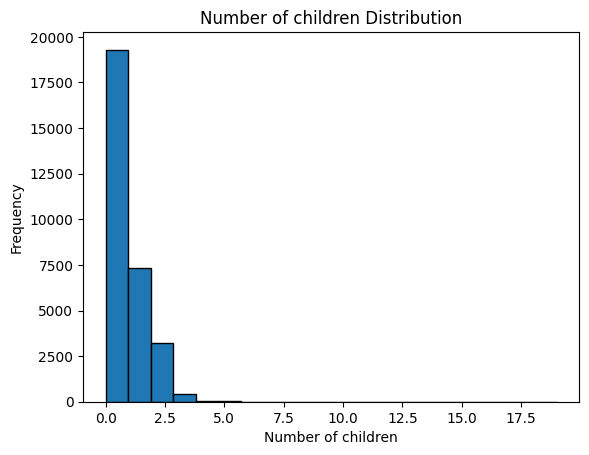

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


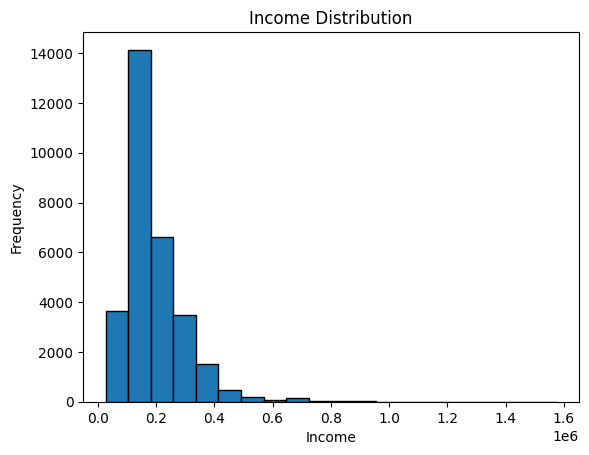

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

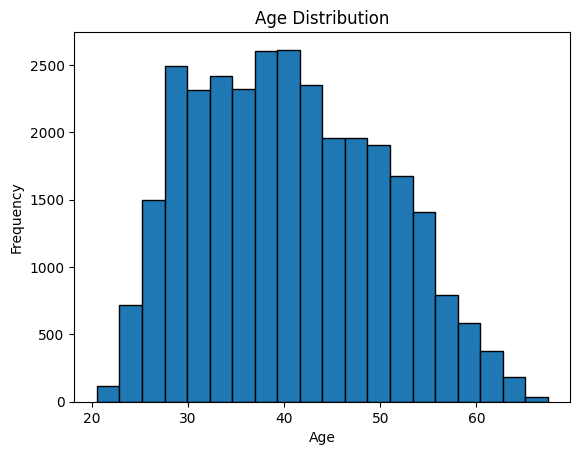

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

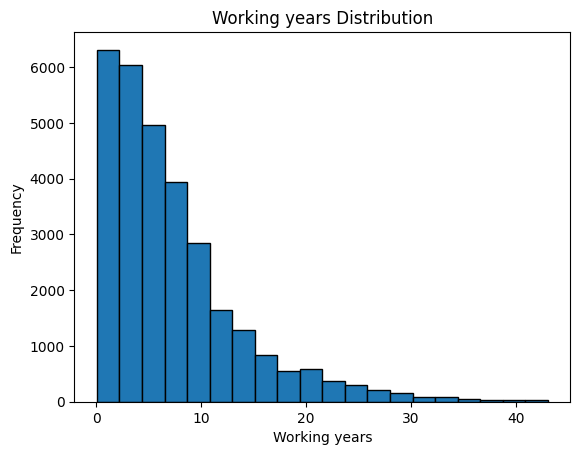

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

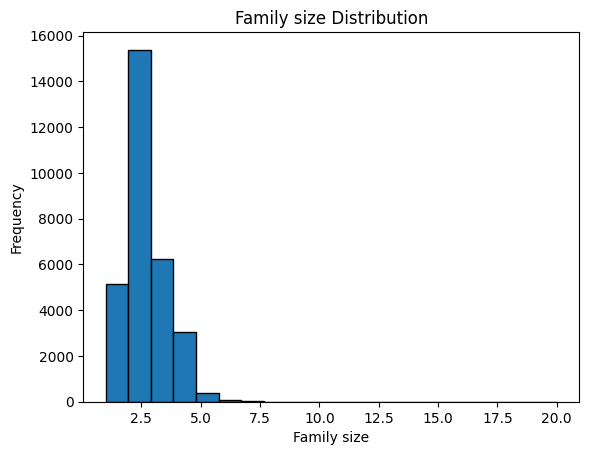

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Call the data preprocessing function
application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Standardized data
scaler = StandardScaler()
application_train = scaler.fit_transform(application_train)
application_test = scaler.transform(application_test)

# Use train_test_split for data splitting
application_train, application_test, customer_label_train, customer_label_test = train_test_split(
    application_train, customer_label_train, test_size=0.3, random_state=42
)



# Build neural network model
# Adjust dropout rate
model = Sequential()
model.add(Dense(256, input_dim=application_train.shape[1], activation='relu'))
model.add(Dropout(0.2))  

# Add 5 hidden layers without regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

# Compile model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

# Set EarlyStopping with increased patience
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights manually
class_counts = np.bincount(customer_label_train)
total_samples = len(customer_label_train)
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

# Train the model and track training history
epochs = 50
batch_size = 32
history = model.fit(
    application_train, customer_label_train,
    validation_data=(application_test, customer_label_test),
    epochs=epochs, batch_size=batch_size, callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Predict test set
customer_label_predict_nn = (model.predict(application_test) > 0.5).astype(int)

# Evaluate model performance
accuracy = accuracy_score(customer_label_test, customer_label_predict_nn)
print("Test Accuracy:", accuracy)


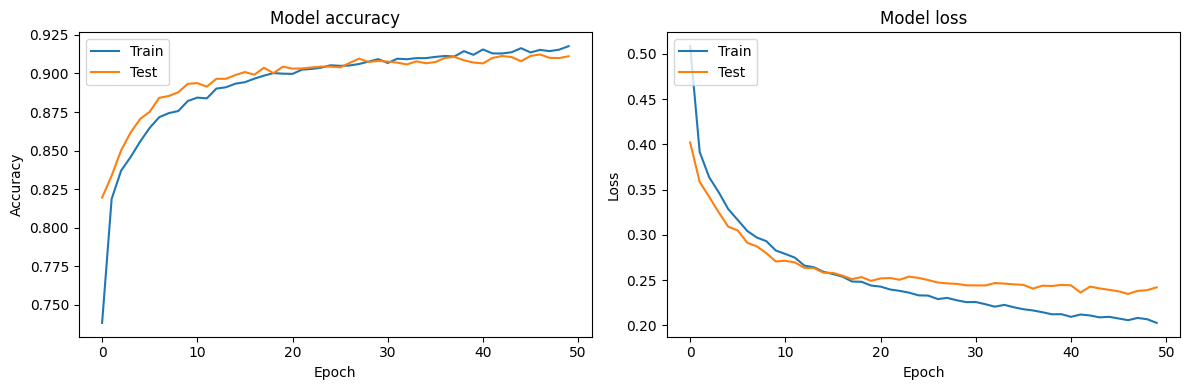

In [6]:
import matplotlib.pyplot as plt


# Plotting training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


## 2.2 Deep Learning

##### Regularization technology (Dropout) has been added to prevent overfitting. At the same time, the Adam optimizer and learning rate adjustment are used.

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

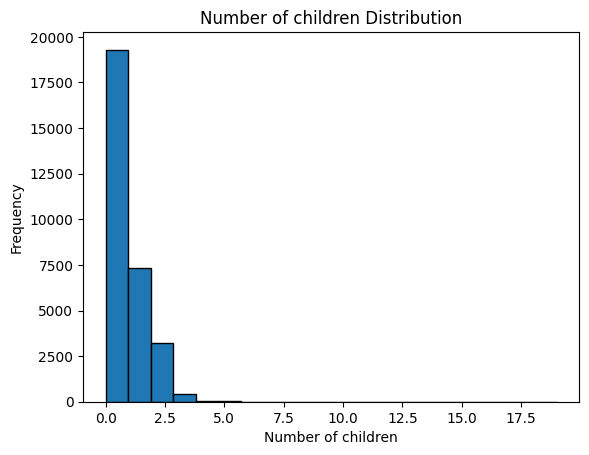

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


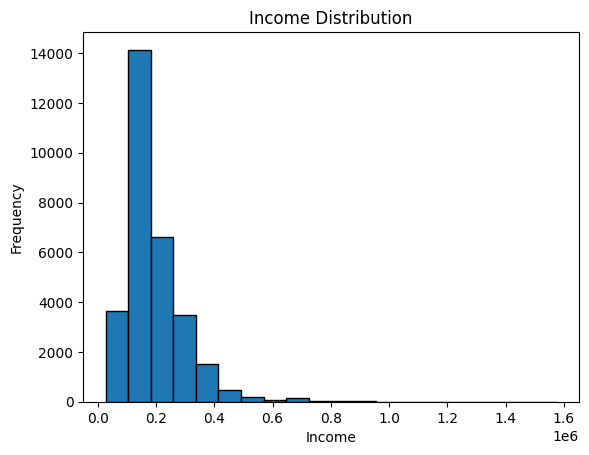

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

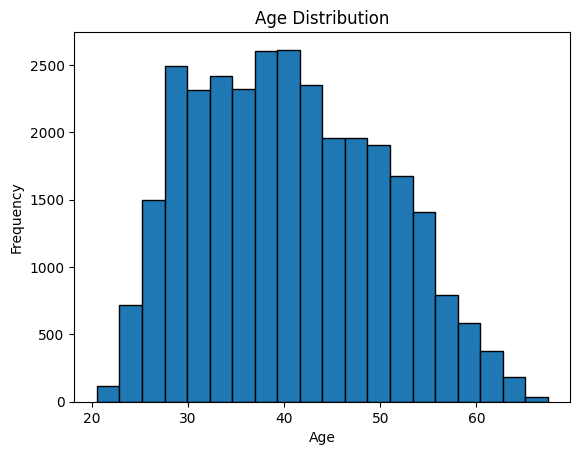

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

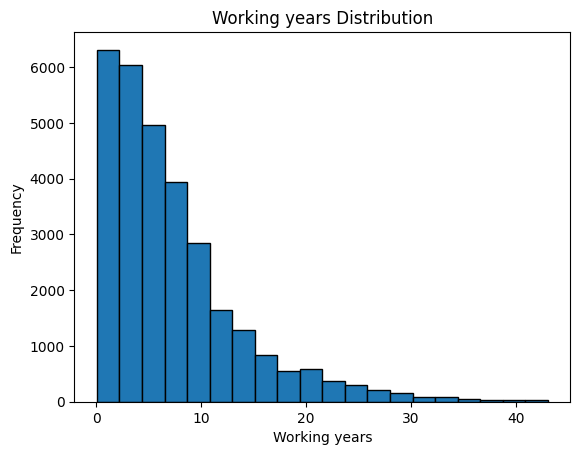

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

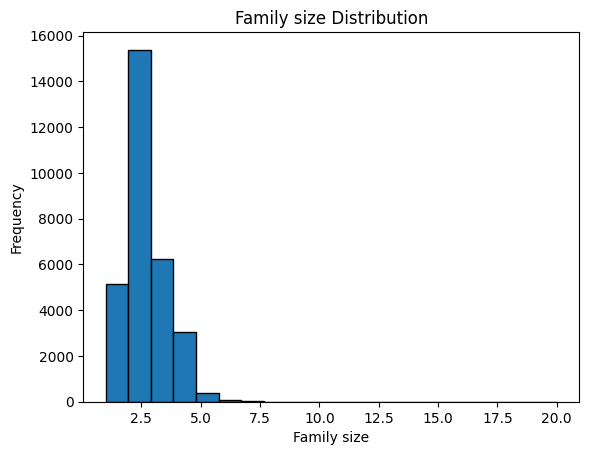

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

C:\Users\Jack Zhang\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


534/534 [==============================] - 6s 12ms/step - loss: 0.4537 - accuracy: 0.8002 - val_loss: 0.3863 - val_accuracy: 0.6971
Epoch 3/50
534/534 [==============================] - 5s 9ms/step - loss: 0.4215 - accuracy: 0.8181 - val_loss: 0.3790 - val_accuracy: 0.7074
Epoch 4/50
534/534 [==============================] - 5s 10ms/step - loss: 0.4014 - accuracy: 0.8274 - val_loss: 0.3393 - val_accuracy: 0.7465
Epoch 5/50
534/534 [==============================] - 5s 9ms/step - loss: 0.3902 - accuracy: 0.8333 - val_loss: 0.3069 - val_accuracy: 0.7647
Epoch 6/50
534/534 [==============================] - 6s 11ms/step - loss: 0.3794 - accuracy: 0.8371 - val_loss: 0.3133 - val_accuracy: 0.7752
Epoch 7/50
534/534 [==============================] - 8s 14ms/step - loss: 0.3716 - accuracy: 0.8417 - val_loss: 0.3075 - val_accuracy: 0.7799
Epoch 8/50
534/534 [==============================] - 8s 14ms/step - loss: 0.3682 - accuracy: 0.8453 - val_loss: 0.2707 - val_accuracy: 0.8068
Epoch 9/50
5

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint




application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Standardized data
scaler = StandardScaler()
application_train = scaler.fit_transform(application_train)
application_test = scaler.transform(application_test)

#Build a deep learning model
model = Sequential()
model.add(Dense(256, input_dim=application_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Set EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)


# Calculate class weights manually
class_counts = np.bincount(customer_label_train)
total_samples = len(customer_label_train)
class_weights = total_samples / (len(class_counts) * class_counts)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))


#Train model
history = model.fit(
    application_train, customer_label_train,
    validation_split=0.2,
    epochs=50, batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    class_weight={0: class_weights[0], 1: class_weights[1]}  # Assuming class_weights is a 1D array
)


#Load the best model
model.load_weights('best_model.h5')

# Predict test set
customer_label_predict_proba = model.predict(application_test)
customer_label_predict_dl = (customer_label_predict_proba > 0.5).astype(int)

# Evaluate model performance
accuracy = accuracy_score(customer_label_test, customer_label_predict_dl)
print("Test Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(customer_label_test, customer_label_predict_dl))

print("\nConfusion Matrix:")
print(confusion_matrix(customer_label_test, customer_label_predict_dl))


In [7]:
import h5py

# Open the H5 file
with h5py.File('best_model.h5', 'r') as file:
   
    print("Keys: ", list(file.keys()))

    # Access and print the details of each dataset within each group
    for group_key in file.keys():
        group = file[group_key]
        print(f"\nGroup: {group_key}")

        for dataset_key in group.keys():
            # Navigate into the subgroup
            subgroup = group[dataset_key]

            # Check if the subgroup is a dataset or another group
            if isinstance(subgroup, h5py.Dataset):
                print(f"\n  Dataset: {dataset_key}")
                print(f"  Shape: {subgroup.shape}")
                print(f"  Datatype: {subgroup.dtype}")
                
                
                # print(subgroup[:])
            elif isinstance(subgroup, h5py.Group):
                print(f"\n  Subgroup: {dataset_key}")
                # You can further navigate into the subgroup if needed
            else:
                print(f"\n  Unknown object type: {dataset_key}")


Keys:  ['model_weights', 'optimizer_weights']

Group: model_weights

  Subgroup: dense

  Subgroup: dense_1

  Subgroup: dense_2

  Subgroup: dense_3

  Subgroup: dropout

  Subgroup: dropout_1

  Subgroup: dropout_2

  Subgroup: top_level_model_weights

Group: optimizer_weights

  Subgroup: Adam

  Dataset: iteration:0
  Shape: ()
  Datatype: int64


190/190 [==============================] - 1s 4ms/step


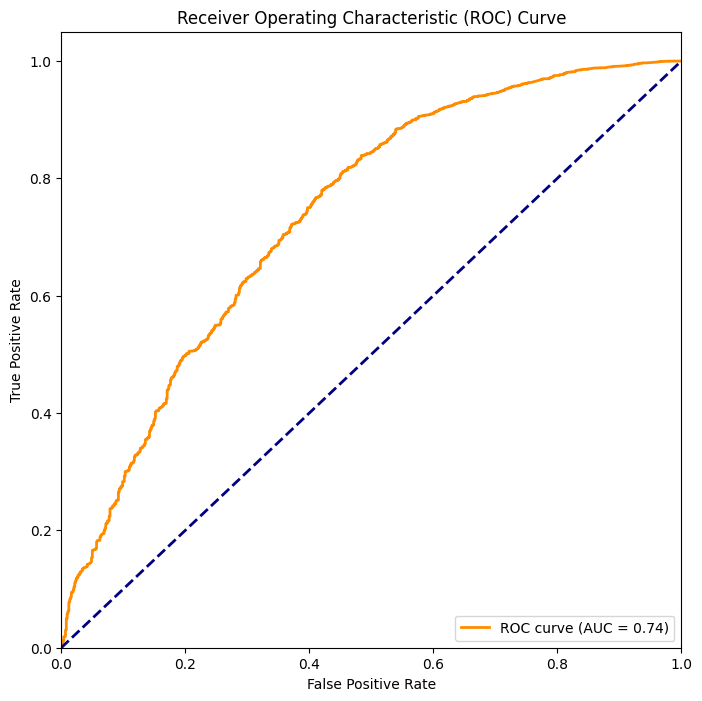

In [7]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict test set probability
customer_label_predict_proba = model.predict(application_test)

# Binary prediction
customer_label_predict_dl = (customer_label_predict_proba > 0.5).astype(int)

# Draw ROC curve
fpr, tpr, thresholds = roc_curve(customer_label_test, customer_label_predict_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## 2.3 SVR

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

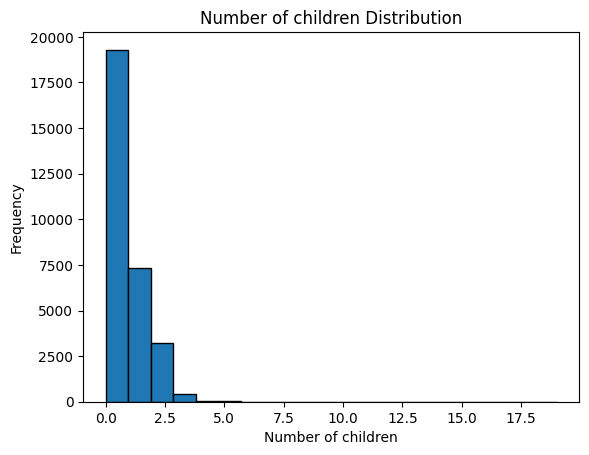

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


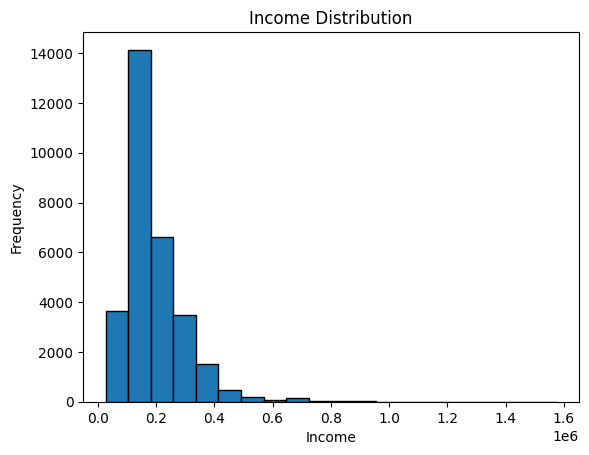

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

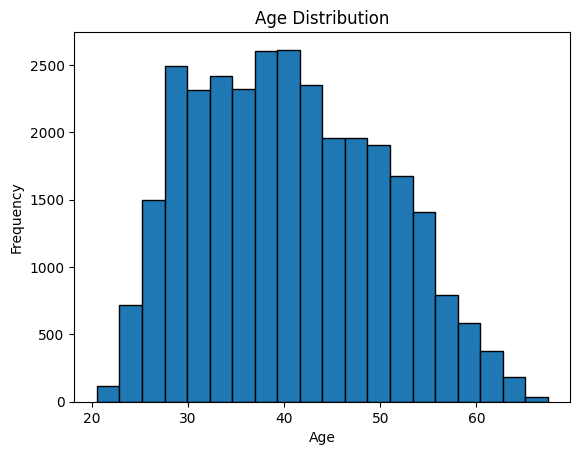

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

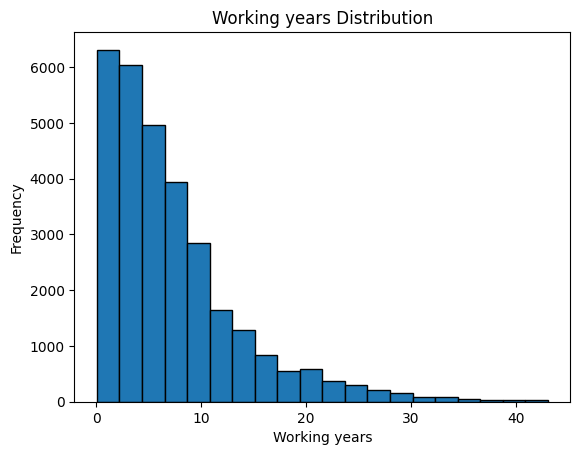

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

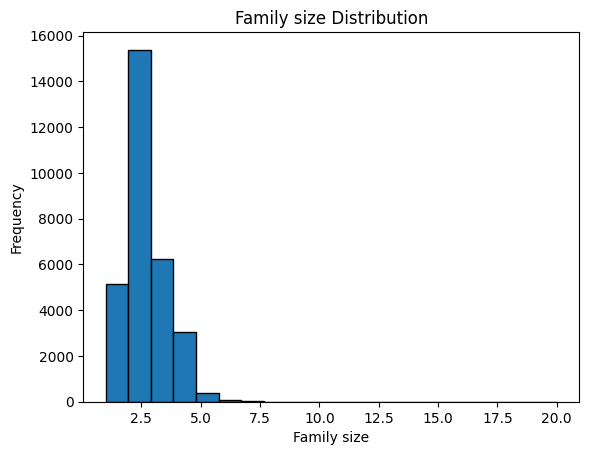

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Use a subset for initial testing
subset_size = 1000  
application_train_subset, _, customer_label_train_subset, _ = train_test_split(
    application_train, customer_label_train, train_size=subset_size, random_state=42
)

# Standardize data
scaler = StandardScaler()
application_train_subset = scaler.fit_transform(application_train_subset)
application_test = scaler.transform(application_test)

# Build and train SVR model with hyperparameter tuning
svr_model = SVR(kernel='linear')
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.01, 0.001]}
grid_search = GridSearchCV(svr_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

try:
    grid_search.fit(application_train_subset, customer_label_train_subset)
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)

    best_svr_model = grid_search.best_estimator_

    # Predict on the test set
    customer_label_predict_svr = best_svr_model.predict(application_test)

    # Evaluate model performance using mean squared error as an example
    mse = mean_squared_error(customer_label_test, customer_label_predict_svr)
    print("Mean Squared Error:", mse)

except Exception as e:
    print("Error during training:", e)


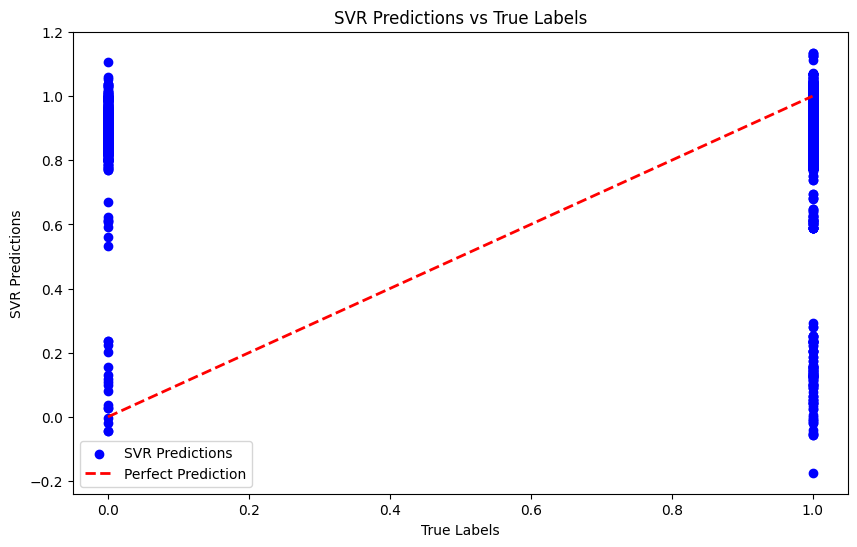

In [10]:
import matplotlib.pyplot as plt

# Plotting the SVR predictions against the true labels
plt.figure(figsize=(10, 6))
plt.scatter(customer_label_test, customer_label_predict_svr, color='blue', label='SVR Predictions')
plt.plot([customer_label_test.min(), customer_label_test.max()], [customer_label_test.min(), customer_label_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('SVR Predictions vs True Labels')
plt.xlabel('True Labels')
plt.ylabel('SVR Predictions')
plt.legend()
plt.show()

## 2.4 XGBoost

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

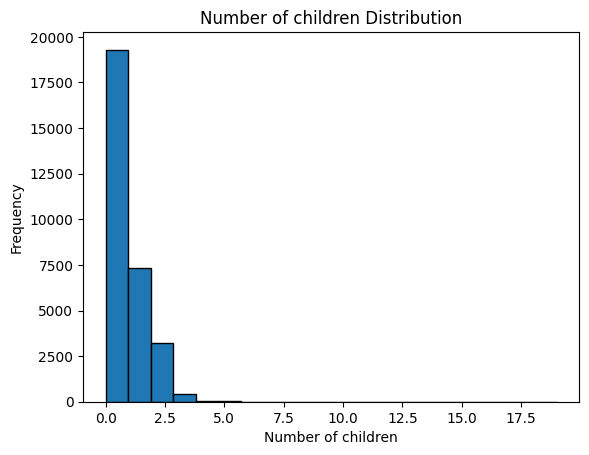

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


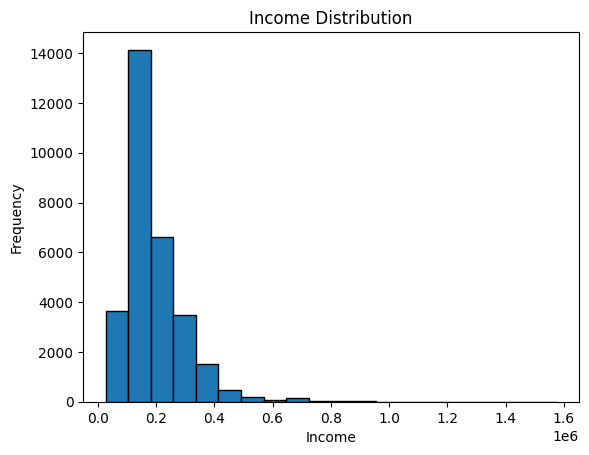

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

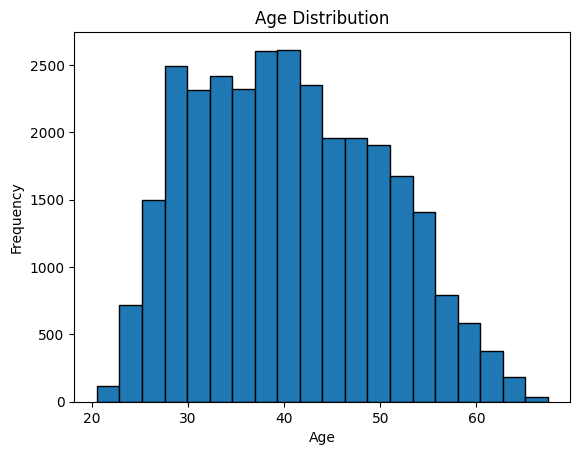

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

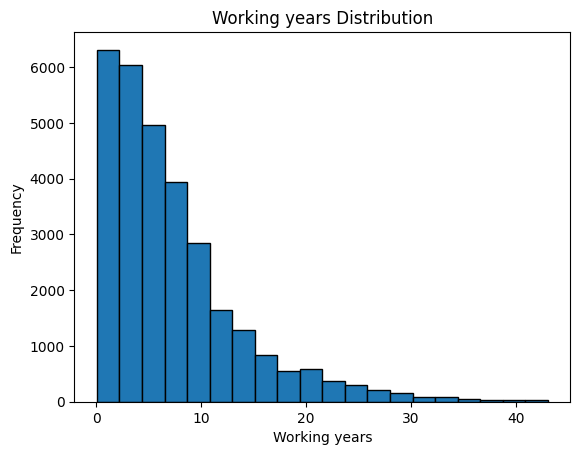

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

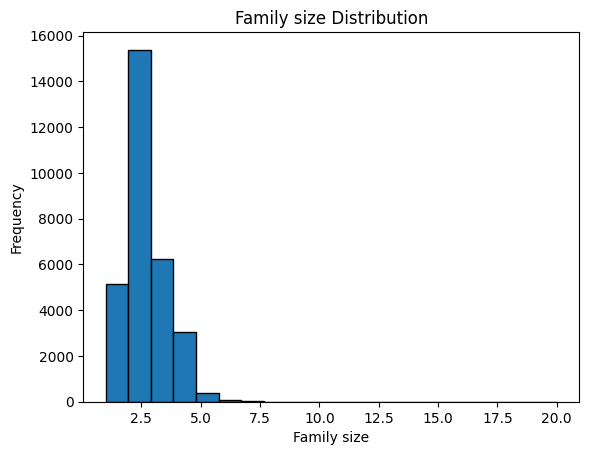

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [11]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Standardize data (although XGBoost does not require normalization, it can sometimes improve performance)
scaler = StandardScaler()
application_train = scaler.fit_transform(application_train)
application_test = scaler.transform(application_test)

#Build XGBoost model
model = XGBClassifier(
    max_depth=12,
    learning_rate=0.02,
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42
)

#Train model
model.fit(application_train, customer_label_train)

#Predict test set
customer_label_predict_xgb = model.predict(application_test)

# Evaluate model performance
accuracy = accuracy_score(customer_label_test, customer_label_predict_xgb)
print("Test Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(customer_label_test, customer_label_predict_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(customer_label_test, customer_label_predict_xgb))


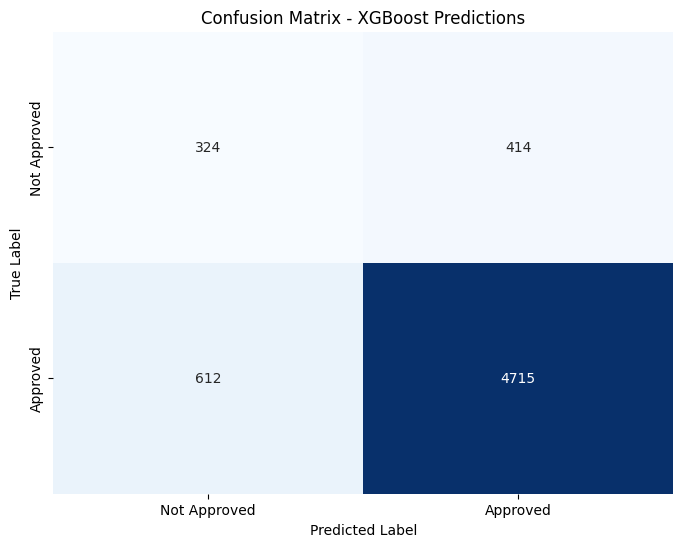

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(customer_label_test, customer_label_predict_xgb)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix - XGBoost Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## 2.5 Linear Regression

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

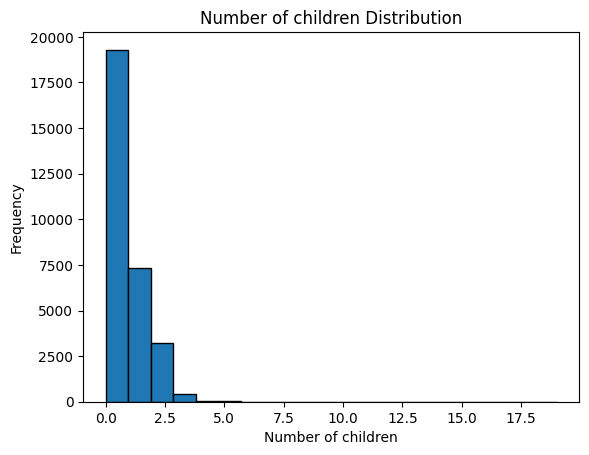

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


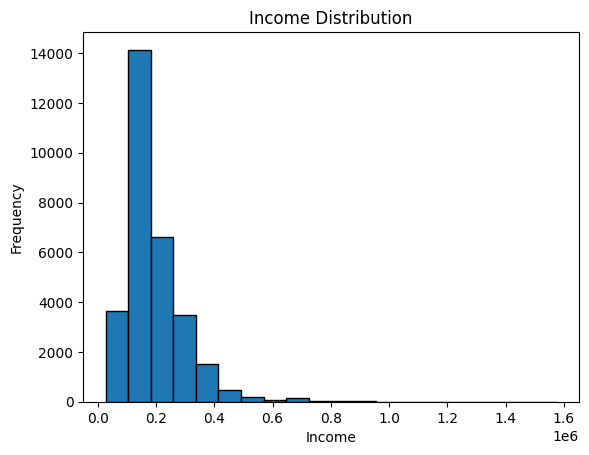

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

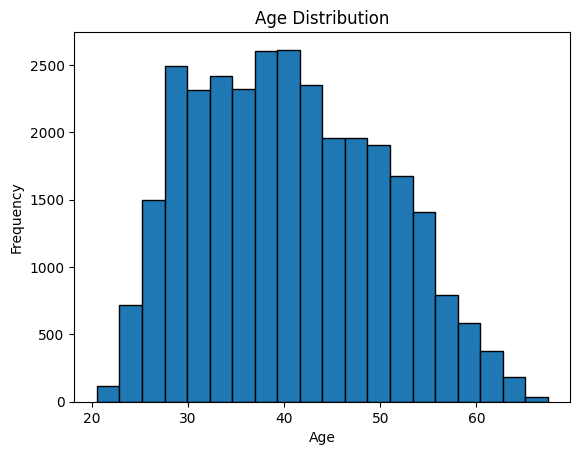

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

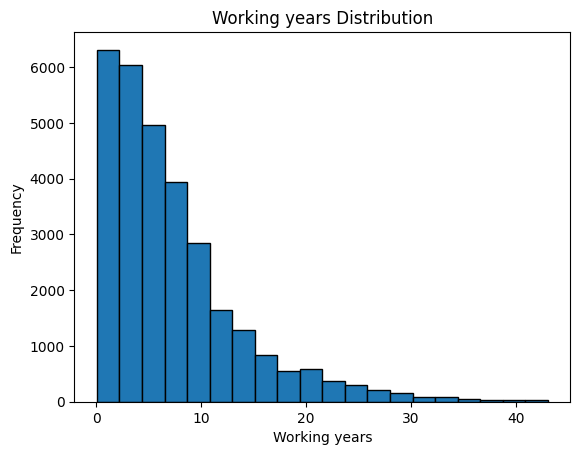

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

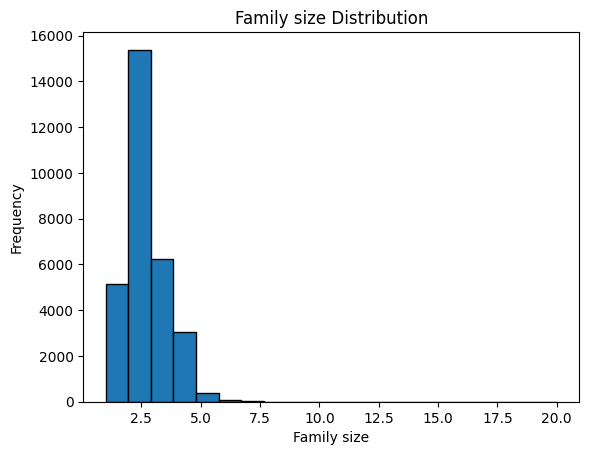

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)
#Build a linear regression model
model = LinearRegression()

#Train model
model.fit(application_train, customer_label_train)

# Predict test set
customer_label_predict_lr = model.predict(application_test)

# Evaluate model performance
mse = mean_squared_error(customer_label_test, customer_label_predict_lr)
r2 = r2_score(customer_label_test, customer_label_predict_lr)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


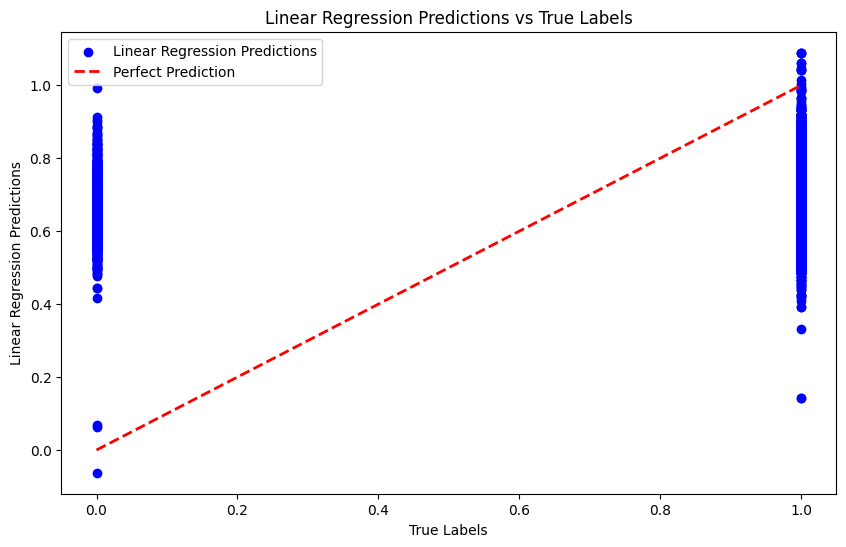

In [15]:
import matplotlib.pyplot as plt

# Plotting the Linear Regression predictions against the true labels
plt.figure(figsize=(10, 6))
plt.scatter(customer_label_test, customer_label_predict_lr, color='blue', label='Linear Regression Predictions')
plt.plot([customer_label_test.min(), customer_label_test.max()], [customer_label_test.min(), customer_label_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.title('Linear Regression Predictions vs True Labels')
plt.xlabel('True Labels')
plt.ylabel('Linear Regression Predictions')
plt.legend()
plt.show()


## 2.6 Logistic Regression

Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

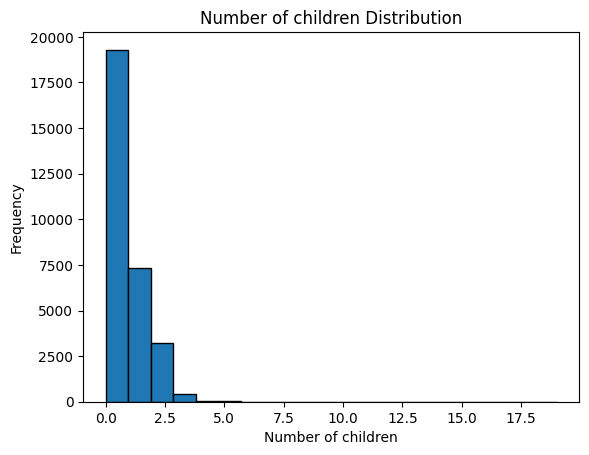

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


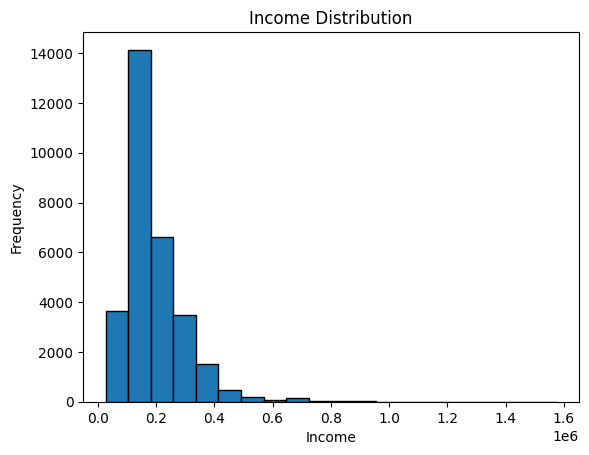

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

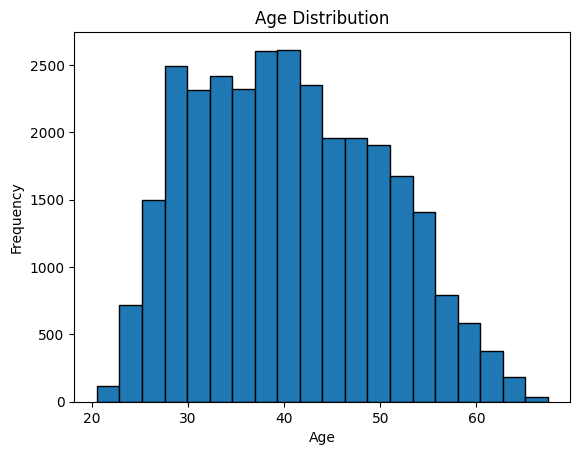

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

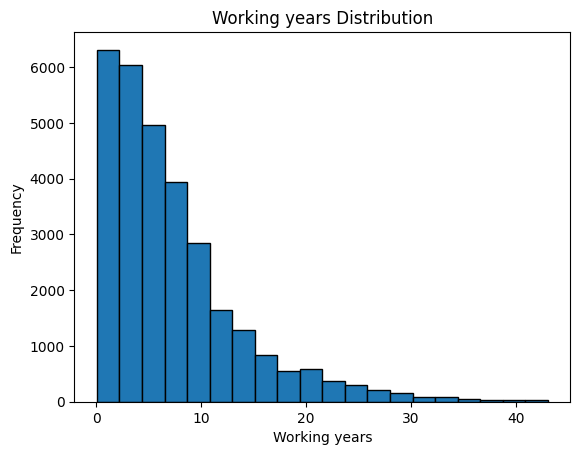

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

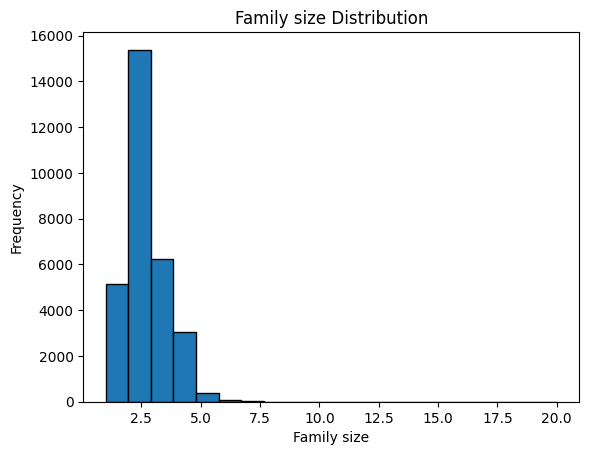

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Standardized data (logistic regression is more sensitive to feature scaling)
scaler = StandardScaler()
application_train = scaler.fit_transform(application_train)
application_test = scaler.transform(application_test)

# Build a logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000) 

#Train model
model.fit(application_train, customer_label_train)

# Predict test set
customer_label_predict_lr = model.predict(application_test)

# Evaluate model performance
accuracy = accuracy_score(customer_label_test, customer_label_predict_lr)
print("Test Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(customer_label_test, customer_label_predict_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(customer_label_test, customer_label_predict_lr))


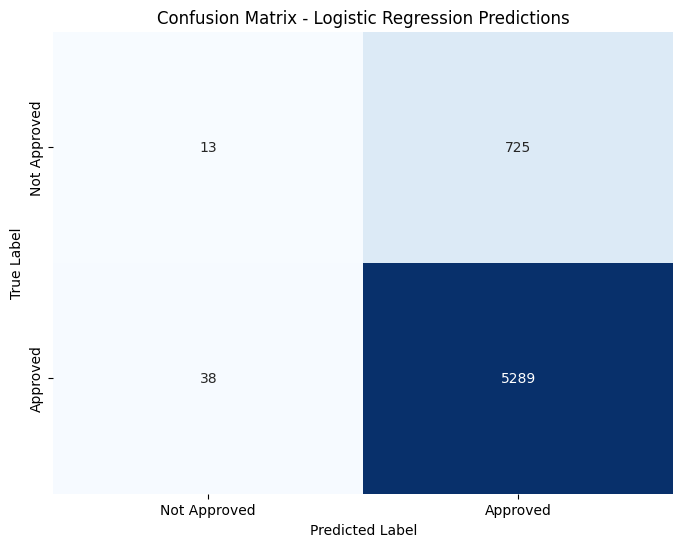

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(customer_label_test, customer_label_predict_lr)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix - Logistic Regression Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## 2.7 Random Forest


Common customers ID: 
 {5112591, 5112592, 5112593, 5112594, 5112597, 5112598, 5112599, 5112600, 5112601, 5112602, 5112603, 5112604, 5112605, 5112606, 5112608, 5112609, 5112611, 5112614, 5112615, 5112616, 5112621, 5112622, 5112623, 5112624, 5112625, 5112626, 5112627, 5112628, 5112629, 5112630, 5112631, 5112632, 5112633, 5112634, 5112636, 5112637, 5112638, 5112639, 5112640, 5112644, 5112645, 5112646, 5112647, 5112648, 5112649, 5112650, 5112651, 5112652, 5112653, 5112654, 5112655, 5112656, 5112657, 5112660, 5112661, 5112662, 5112663, 5112664, 5112665, 5112666, 5112672, 5112673, 5112674, 5112675, 5112676, 5112677, 5112681, 5112682, 5112683, 5112684, 5112685, 5112686, 5112687, 5112688, 5112689, 5112690, 5112691, 5112692, 5112693, 5112694, 5112695, 5112696, 5112699, 5112700, 5112701, 5112702, 5112703, 5112705, 5112707, 5112708, 5112709, 5112710, 5112711, 5112715, 5112716, 5112717, 5112722, 5112724, 5112725, 5112726, 5112729, 5112730, 5112731, 5112732, 5112733, 5112734, 5112735, 5112736, 5112

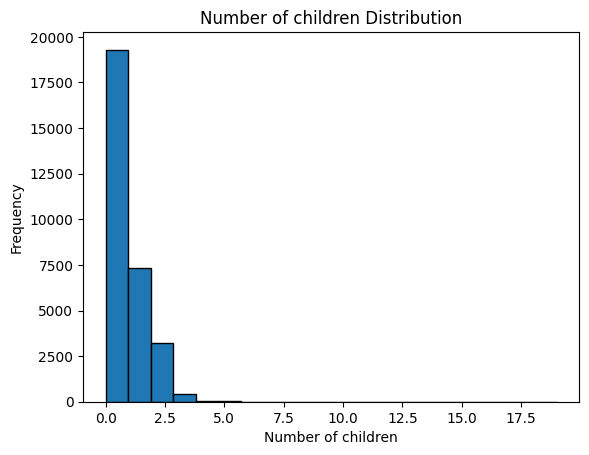

Number of children Distribution: 

Bin 1: 0.0 - 0.95--19294.0--0.6363036739001385
Bin 2: 0.95 - 1.9--7325.0--0.24157377481696457
Bin 3: 1.9 - 2.8499999999999996--3214.0--0.10599564672515005
Bin 4: 2.8499999999999996 - 3.8--400.0--0.013191741969527077
Bin 5: 3.8 - 4.75--63.0--0.0020776993602005145
Bin 6: 4.75 - 5.699999999999999--20.0--0.0006595870984763538
Bin 7: 5.699999999999999 - 6.6499999999999995--0.0--0.0
Bin 8: 6.6499999999999995 - 7.6--2.0--6.595870984763538e-05
Bin 9: 7.6 - 8.549999999999999--0.0--0.0
Bin 10: 8.549999999999999 - 9.5--0.0--0.0
Bin 11: 9.5 - 10.45--0.0--0.0
Bin 12: 10.45 - 11.399999999999999--0.0--0.0
Bin 13: 11.399999999999999 - 12.35--0.0--0.0
Bin 14: 12.35 - 13.299999999999999--0.0--0.0
Bin 15: 13.299999999999999 - 14.25--3.0--9.893806477145307e-05
Bin 16: 14.25 - 15.2--0.0--0.0
Bin 17: 15.2 - 16.15--0.0--0.0
Bin 18: 16.15 - 17.099999999999998--0.0--0.0
Bin 19: 17.099999999999998 - 18.05--0.0--0.0
Bin 20: 18.05 - 19.0--1.0--3.297935492381769e-05


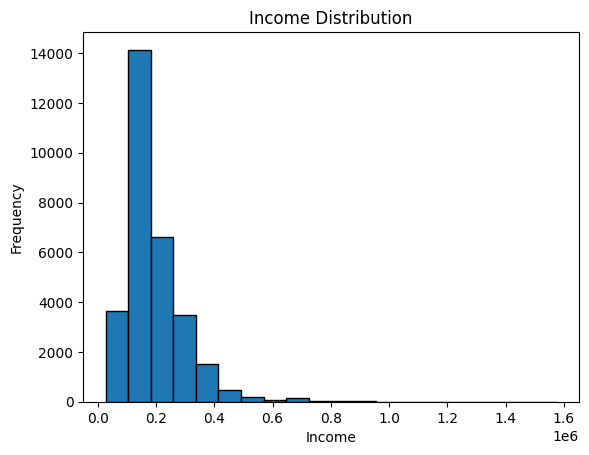

Annual income Distribution: 

Bin 1: 27000.0 - 104400.0--3632.0--0.11978101708330585
Bin 2: 104400.0 - 181800.0--14138.0--0.4662621199129345
Bin 3: 181800.0 - 259200.0--6628.0--0.21858716443506365
Bin 4: 259200.0 - 336600.0--3466.0--0.11430644416595212
Bin 5: 336600.0 - 414000.0--1501.0--0.04950201174065035
Bin 6: 414000.0 - 491400.0--467.0--0.015401358749422861
Bin 7: 491400.0 - 568800.0--179.0--0.005903304531363366
Bin 8: 568800.0 - 646200.0--77.0--0.002539410329133962
Bin 9: 646200.0 - 723600.0--141.0--0.0046500890442582946
Bin 10: 723600.0 - 801000.0--14.0--0.0004617109689334477
Bin 11: 801000.0 - 878400.0--15.0--0.0004946903238572653
Bin 12: 878400.0 - 955800.0--43.0--0.0014181122617241606
Bin 13: 955800.0 - 1033200.0--4.0--0.00013191741969527076
Bin 14: 1033200.0 - 1110600.0--0.0--0.0
Bin 15: 1110600.0 - 1188000.0--3.0--9.893806477145307e-05
Bin 16: 1188000.0 - 1265400.0--0.0--0.0
Bin 17: 1265400.0 - 1342800.0--0.0--0.0
Bin 18: 1342800.0 - 1420200.0--6.0--0.00019787612954290615
B

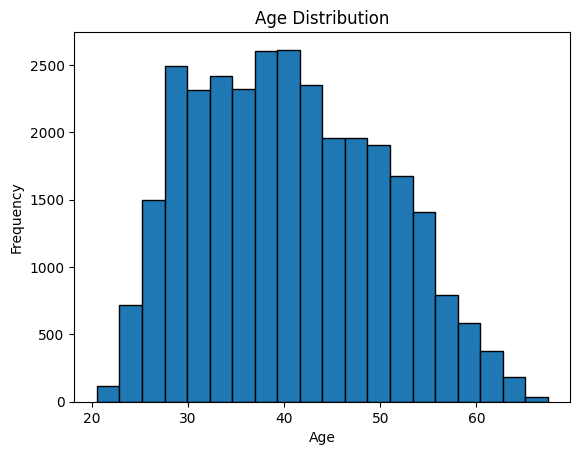

Age Distribution: 

Bin 1: 20.517808219178082 - 22.86328767123288--114.0--0.0037596464613152167
Bin 2: 22.86328767123288 - 25.20876712328767--719.0--0.02371215619022492
Bin 3: 25.20876712328767 - 27.554246575342468--1498.0--0.0494030736758789
Bin 4: 27.554246575342468 - 29.899726027397264--2489.0--0.08208561440538223
Bin 5: 29.899726027397264 - 32.24520547945205--2315.0--0.07634720664863795
Bin 6: 32.24520547945205 - 34.59068493150686--2417.0--0.07971110085086736
Bin 7: 34.59068493150686 - 36.936164383561646--2323.0--0.0766110414880285
Bin 8: 36.936164383561646 - 39.28164383561644--2604.0--0.08587824022162127
Bin 9: 39.28164383561644 - 41.62712328767124--2612.0--0.0861420750610118
Bin 10: 41.62712328767124 - 43.97260273972603--2348.0--0.07743552536112394
Bin 11: 43.97260273972603 - 46.31808219178083--1955.0--0.06447463887606358
Bin 12: 46.31808219178083 - 48.66356164383562--1960.0--0.06463953565068267
Bin 13: 48.66356164383562 - 51.00904109589042--1904.0--0.06279269177494888
Bin 14: 51

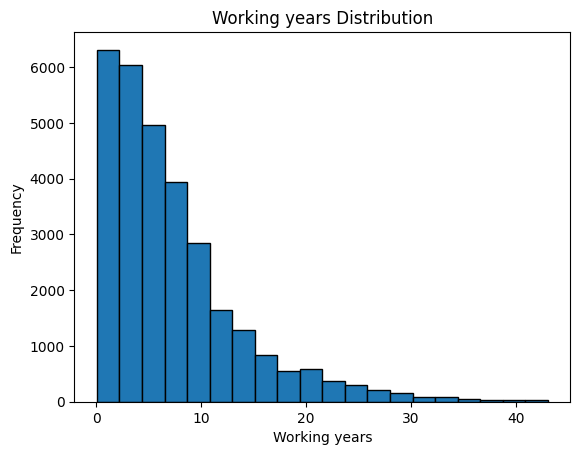

Working years Distribution: 

Bin 1: 0.04657534246575343 - 2.1967123287671235--6311.0--0.20813270892421346
Bin 2: 2.1967123287671235 - 4.346849315068494--6031.0--0.19889848954554448
Bin 3: 4.346849315068494 - 6.496986301369864--4967.0--0.16380845590660248
Bin 4: 6.496986301369864 - 8.647123287671235--3945.0--0.1301035551744608
Bin 5: 8.647123287671235 - 10.797260273972604--2842.0--0.09372732669348988
Bin 6: 10.797260273972604 - 12.947397260273975--1638.0--0.05402018336521338
Bin 7: 12.947397260273975 - 15.097534246575346--1284.0--0.04234549172218192
Bin 8: 15.097534246575346 - 17.247671232876716--842.0--0.027768616845854494
Bin 9: 17.247671232876716 - 19.397808219178085--557.0--0.018369500692566453
Bin 10: 19.397808219178085 - 21.547945205479454--583.0--0.019226963920585715
Bin 11: 21.547945205479454 - 23.698082191780827--373.0--0.012301299386583999
Bin 12: 23.698082191780827 - 25.848219178082196--291.0--0.009596992282830948
Bin 13: 25.848219178082196 - 27.998356164383566--211.0--0.006

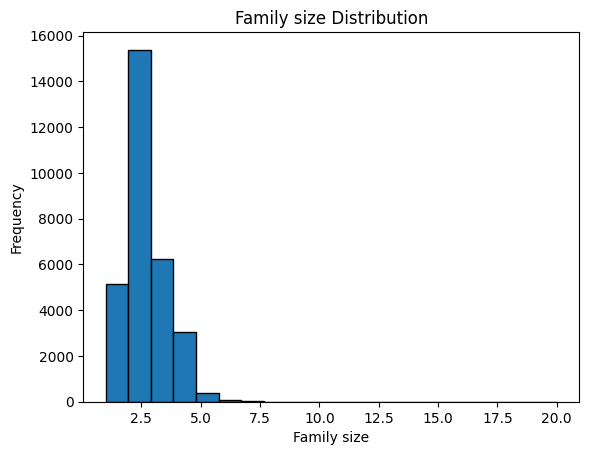

Family size Distribution: 

Bin 1: 1.0 - 1.95--5151.0--0.1698766572125849
Bin 2: 1.95 - 2.9--15389.0--0.5075192929226304
Bin 3: 2.9 - 3.8499999999999996--6255.0--0.20628586504847965
Bin 4: 3.8499999999999996 - 4.8--3057.0--0.10081788800211068
Bin 5: 4.8 - 5.75--387.0--0.012763010355517445
Bin 6: 5.75 - 6.699999999999999--58.0--0.001912802585581426
Bin 7: 6.699999999999999 - 7.6499999999999995--19.0--0.0006266077435525361
Bin 8: 7.6499999999999995 - 8.6--0.0--0.0
Bin 9: 8.6 - 9.549999999999999--2.0--6.595870984763538e-05
Bin 10: 9.549999999999999 - 10.5--0.0--0.0
Bin 11: 10.5 - 11.45--0.0--0.0
Bin 12: 11.45 - 12.399999999999999--0.0--0.0
Bin 13: 12.399999999999999 - 13.35--0.0--0.0
Bin 14: 13.35 - 14.299999999999999--0.0--0.0
Bin 15: 14.299999999999999 - 15.25--3.0--9.893806477145307e-05
Bin 16: 15.25 - 16.2--0.0--0.0
Bin 17: 16.2 - 17.15--0.0--0.0
Bin 18: 17.15 - 18.099999999999998--0.0--0.0
Bin 19: 18.099999999999998 - 19.05--0.0--0.0
Bin 20: 19.05 - 20.0--1.0--3.297935492381769e-05
C

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


application_train, application_test, customer_label_train, customer_label_test = dataPreprocessing(
    'application_record.csv',
    'credit_record.csv', 'OneHot'
)

# Build a random forest model
model = RandomForestClassifier(
    n_estimators=100,  
    max_depth=3,       
    random_state=42
)

#Train model
model.fit(application_train, customer_label_train)

# Predict test set
customer_label_predict_rf = model.predict(application_test)

# Evaluate model performance
accuracy = accuracy_score(customer_label_test, customer_label_predict_rf)
print("Test Accuracy:", accuracy)

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(customer_label_test, customer_label_predict_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(customer_label_test, customer_label_predict_rf))


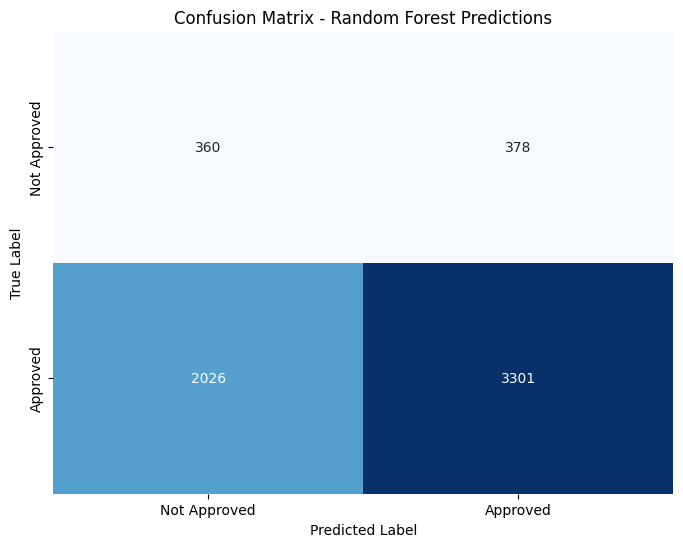

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(customer_label_test, customer_label_predict_rf)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix - Random Forest Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
